In [596]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [597]:
dt = 0.1  # delta time
sp = 1.5 # Sigma for position noise

# initial state
x = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
# initial uncertainty
P = 100.0*np.eye(6)
# dynamic matrix
A = np.matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, dt, 0.0],
              [0.0, 0.0, 1.0, 0.0, 0.0, dt],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
# measurement matrix
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])
# measurement noise covariance
ra = 1.5
R = np.matrix([[ra, 0.0, 0.0],
              [0.0, ra, 0.0],
              [0.0, 0.0, ra]])
# process noise covariance
sv = 0.0
G = np.matrix([[1/2.0*dt**2],
               [1/2.0*dt**2],
               [1/2.0*dt**2],
               [dt],
               [dt],
               [dt]])
Q = G*G.T*sv
# identity matrix
I = np.eye(6)


In [598]:
T = 100.0 # s measuremnt time
m = int(T/dt) # number of measurements

px= 0.0 # x Position Start
py= 0.0 # y Position Start
pz= 0.0 # z Position Start

vx = 0.0 # m/s Velocity
vy = 0.0 # m/s Velocity
vz = 0.0 # m/s Velocity

Xr=[]
Yr=[]
Zr=[]

for i in range(m):
    px += vx*i*dt
    py += vy*i*dt
    pz += vz*i*dt
        
    Xr.append(px)
    Yr.append(py)
    Zr.append(pz)

In [599]:
# Skewed along the x-axis
Xm = Xr + sp * (np.random.randn(m))
Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))

In [600]:
measurements = np.vstack((Xm,Ym,Zm))

(-6.478276006402395, 6.492978251262991)

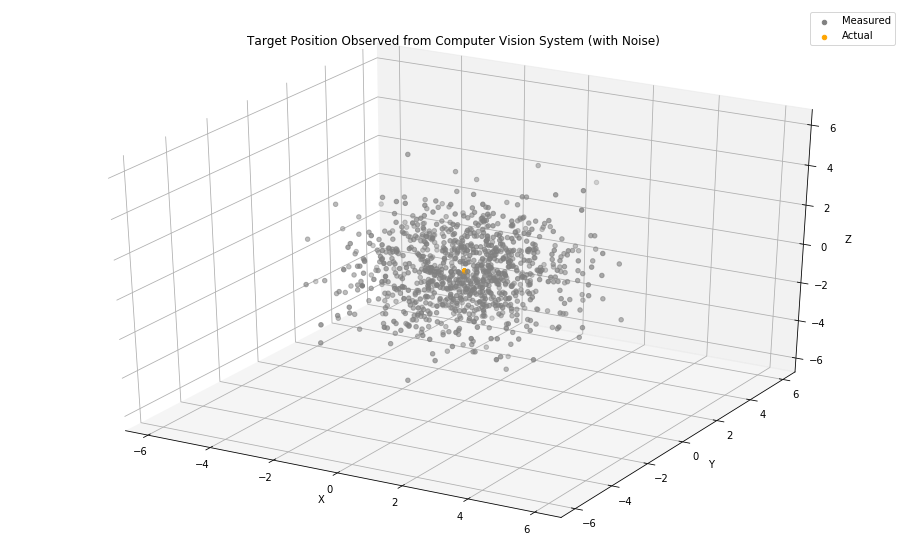

In [601]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cXm,cYm,cXm, label='Camera Measured Position')
ax.scatter(Xm, Ym, Zm, c='gray', label='Measured')
ax.scatter(Xr, Yr, Zr, c='orange', label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Target Position Observed from Computer Vision System (with Noise)')
plt.legend()

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Axis equal
max_range = np.array([Xm.max()-Xm.min(),Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 2.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)

In [602]:
xt = []
yt = []
zt = []

Px = []
Py = []
Pz = []

for n in range(len(measurements[0])):
    
    # Adaptive Measurement Covariance R from last i Measurements
    # as an Maximum Likelihood Estimation
#     i = 50
#     if n>i:
#         R = np.matrix([[np.std(measurements[0,(n-i):n])**2, 0.0, 0.0],
#                       [0.0, np.std(measurements[1,(n-i):n])**2, 0.0],
#                       [0.0, 0.0, np.std(measurements[2,(n-i):n])**2]])
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x 
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(H.shape[0],1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    zt.append(float(x[2]))
    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pz.append(float(P[2,2]))

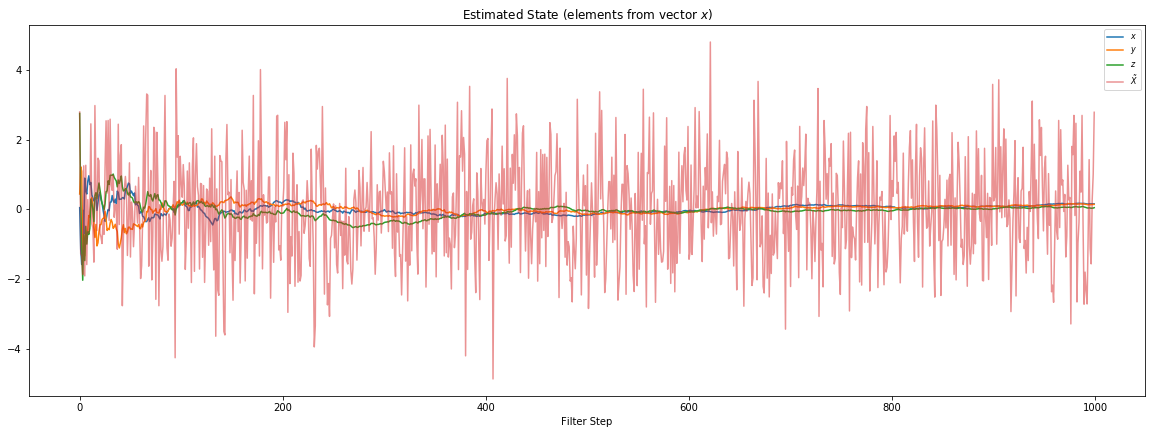

In [607]:
fig = plt.figure(figsize=(20,15))
plt.subplot(211)
plt.title('Estimated State (elements from vector $x$)')
plt.plot(range(len(measurements[0])),xt, label='$x$')
plt.plot(range(len(measurements[0])),yt, label='$y$')
plt.plot(range(len(measurements[0])),zt, label='$z$')
plt.plot(range(len(measurements[0])),Zm, label='$\~X$', alpha=0.5)
plt.legend(loc='best',prop={'size':8})

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':8})

(-6.478276006402395, 6.492978251262991)

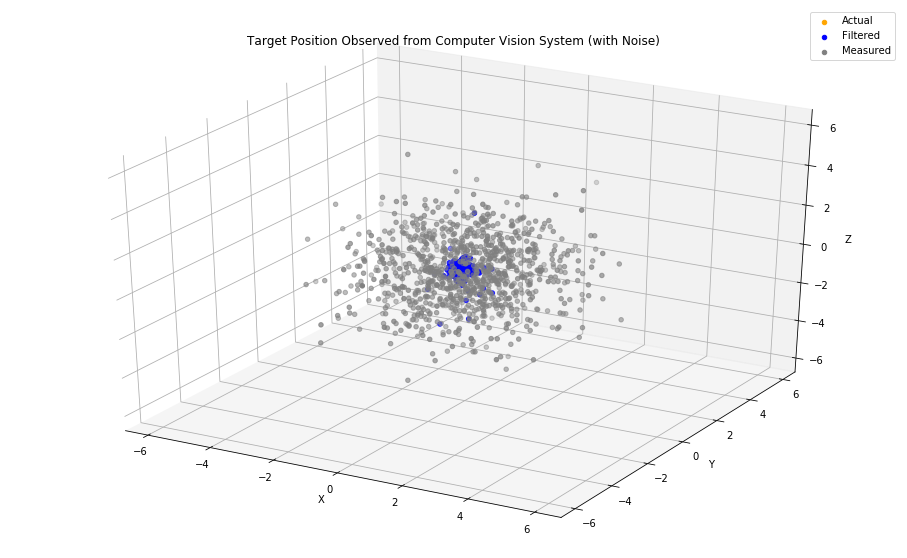

In [604]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cXm,cYm,cXm, label='Camera Measured Position')
# ax.scatter(Xm, Ym, Zm, c='gray', label='Measured')
ax.scatter(Xr, Yr, Zr, c='orange', label='Actual')
ax.scatter(xt, yt, zt, c='blue', label='Filtered', zorder=100)
ax.scatter(Xm, Ym, Zm, c='grey', label='Measured')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Target Position Observed from Computer Vision System (with Noise)')
plt.legend()

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Axis equal
max_range = np.array([Xm.max()-Xm.min(),Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 2.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)

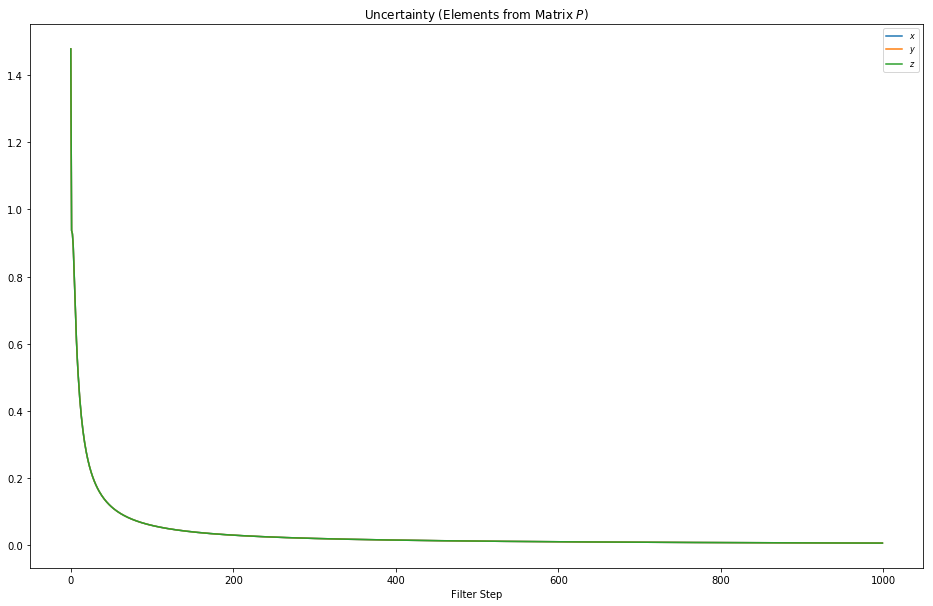

In [605]:
fig = plt.figure(figsize=(16,10))
plt.plot(range(len(measurements[0])),Px, label='$x$')
plt.plot(range(len(measurements[0])),Py, label='$y$')
plt.plot(range(len(measurements[0])),Pz, label='$z$')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':8})

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':8})

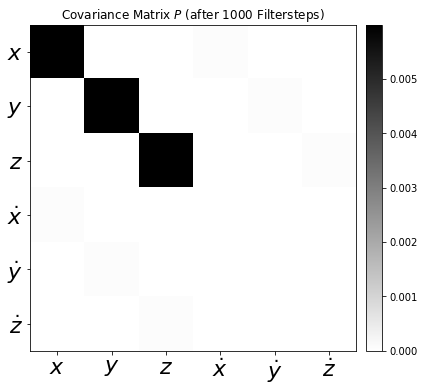

In [606]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filtersteps)' % m)
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(10))
# set the locations and labels of the yticks
plt.yticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$'), fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()